# MBTI Personality Classification Model Based on NLP

In [4]:
import transformers

## Backgroud & Intro
The <b>Myers-Briggs Type Indicator (MBTI)</b> was constructed by Katharine Cook Briggs and her daughter Isabel Briggs Myers. This MBTI indicator aims to make intractable theories of psychological types understandable and useful in daily lives. Participants would get a general and objective view of their personalities by filling out a questionare that takes about 30 minutes. <br><br>

The MBTI has applications in diagnosing organisational issues, teamwork (particularly quality systems), communication, counselling, careers, strategic thinking, performance appraisal, leadership and stress management.  Nowadays, the MBTI test is used as a hiring strategy for 88% of the Fortune 500 companies. It helps HR officers in large companies to determine whether your personality is suitable for the postion you applied. <br><br>

Link for MBTI test (free): https://www.16personalities.com/free-personality-test<br>
Reference: 
1. __[Detailed explanation and more info about MBTI](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/)__
2. __[Understand MBTI](https://www.personalitypathways.com/MBTI_geyer-2.html#:~:text=The%20MBTI%20has%20applications%20in,change%20situations%20in%20different%20ways.)__

## Dataset
The dataset I will be using is scraped from __[PersonalityCafe Forum](https://www.personalitycafe.com/)__, including a sample size of more than 8,000. For each of the individual in this dataset, their type of MBTI personality and posts are recorded for further analysis.<br><br>
Link to Dataset: https://www.kaggle.com/datasets/datasnaek/mbti-type

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # data processing

In [2]:
data=pd.read_csv("mbti_1.csv")
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


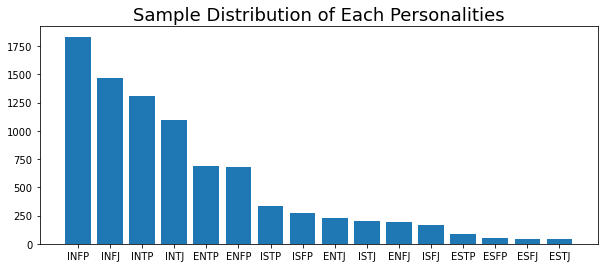

In [3]:
plt.figure(figsize=(10, 4))
plt.bar(data['type'].value_counts().index,data['type'].value_counts())
plt.title('Sample Distribution of Each Personalities',fontsize=18)
plt.show()

## Data Processing

In [4]:
from tqdm import tqdm
import re
from sklearn.preprocessing import LabelEncoder

In [5]:
def text_processing(data):
    out=[]
    url_pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    for post in tqdm(data['posts']):
        #lowercase
        post=post.lower()
        #remove links
        post=re.sub(url_pattern,'LINK',post)        
        #remove non-alphanumeric except for apostrophes
        post=re.sub('[^a-zA-Z\s\']',' ',post)     
        out.append(post)
    return out

In [6]:
data['words']=text_processing(data)
data['word_count']=data['words'].apply(lambda x: len(x.split()))
encoder=LabelEncoder()
data['label']=encoder.fit_transform(data['type'])
data.head()

100%|██████████| 8675/8675 [00:01<00:00, 6546.40it/s]


,type,posts,words,word_count,label
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'LINK LINK enfp and intj moments LINK sp...,600,8
1,ENTP,'I'm finding the lack of me in these posts ver...,'i'm finding the lack of me in these posts ver...,1216,3
2,INTP,'Good one _____ https://www.youtube.com/wat...,'good one LINK of course to which ...,859,11
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",'dear intp i enjoyed our conversation the o...,1102,10
4,ENTJ,'You're fired.|||That's another silly misconce...,'you're fired that's another silly misconce...,1019,2


100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


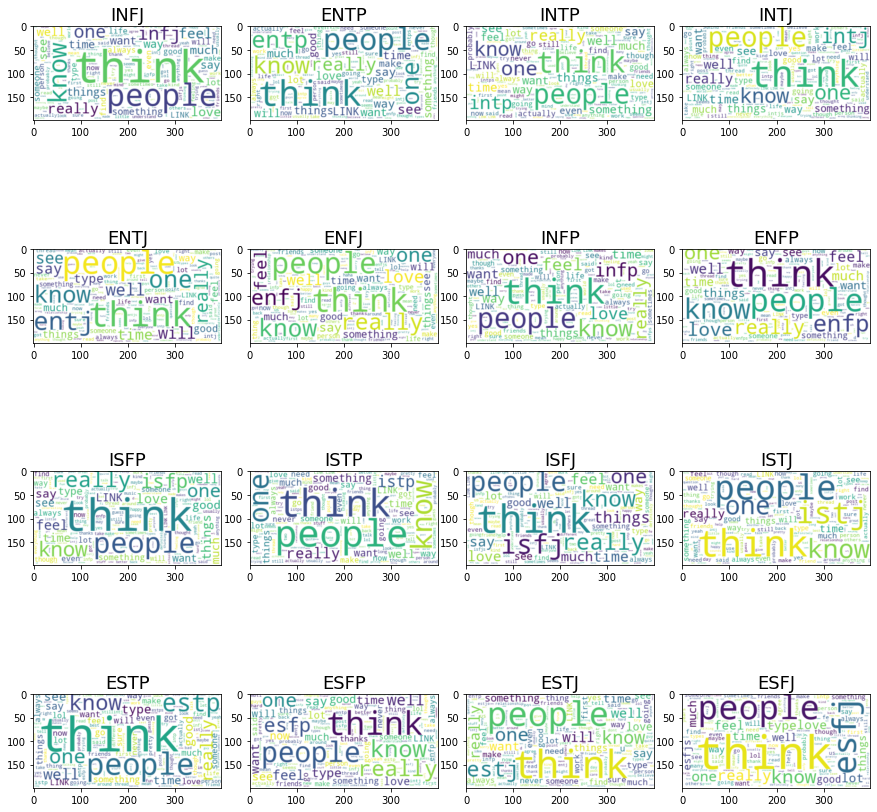

In [7]:
from wordcloud import WordCloud

fig, ax = plt.subplots(16, sharex=True, figsize=(15,16))

count = 0
for i in tqdm(data['type'].unique()):
    temp = data[data['type'] == i]
    text= " ".join(list(temp['words']))
    
    wordcloud = WordCloud(max_words=200,
                          background_color = 'White',
                          relative_scaling=1,
                          normalize_plurals=False).generate(text)
    
    plt.subplot(4,4,count+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i,fontsize=18)
    ax[count].axis("off")
    count+=1

plt.subplots_adjust(wspace=0.15, 
                    hspace=0.1)
plt.show()

## Tokenization and Train-Test Split

In [8]:
import sys
print(sys.executable)

/opt/homebrew/anaconda3/bin/python


In [11]:
data.head()

,type,posts,words,word_count,label
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'LINK LINK enfp and intj moments LINK sp...,600,8
1,ENTP,'I'm finding the lack of me in these posts ver...,'i'm finding the lack of me in these posts ver...,1216,3
2,INTP,'Good one _____ https://www.youtube.com/wat...,'good one LINK of course to which ...,859,11
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",'dear intp i enjoyed our conversation the o...,1102,10
4,ENTJ,'You're fired.|||That's another silly misconce...,'you're fired that's another silly misconce...,1019,2


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)#reducing the number of features for complexity
X=vectorizer.fit_transform(data['words']).todense()
y=data['label']

In [15]:
# stratified train-test split for unbanlanced data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.3, 
                                                    stratify=data.type, 
                                                    random_state=1118)
print('Train X: ',X_train.shape)
print('Test X: ', X_test.shape)
print('Train Y: ',y_train.shape)
print('Test Y: ', y_test.shape)

Train X:  (6072, 3000)
Test X:  (2603, 3000)
Train Y:  (6072,)
Test Y:  (2603,)


## Model Selection

In [46]:
from sklearn.metrics import classification_report,r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score

### Logistic Model (Baseline)

$$p(y|X)=\frac{ e^{w^TX}}{1+e^{w^TX}} + C||w||_2$$

100%|██████████| 5/5 [01:54<00:00, 22.86s/it]


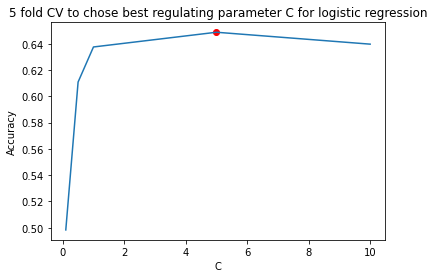

In [58]:
from sklearn.linear_model import LogisticRegression

c_logit=[0.1,0.5,1,5,10]
scores_logit=[]
for i in tqdm(c_logit):
    #weights=dict(zip(data['label'].value_counts(normalize=True).index,data['label'].value_counts(normalize=True)))
    logit=LogisticRegression(max_iter=1000,C=i)
    logit.fit(X_train, y_train)
    scores_logit.append(np.mean(cross_val_score(logit, X_train, y_train, cv=5,scoring='accuracy')))
    
plt.plot(c_logit,scores_logit)
plt.title('5 fold CV to chose best regulating parameter C for logistic regression')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.scatter(c_logit[3],scores_logit[3],color='red')

In [59]:
logit_best=LogisticRegression(max_iter=1000,C=5)
logit_best.fit(X_train, y_train)
print(classification_report(y_test,
                            logit_best.predict(X_test),
                            target_names=encoder.inverse_transform([i for i in range(16)]),
                           zero_division=0))

              precision    recall  f1-score   support

        ENFJ       0.64      0.37      0.47        57
        ENFP       0.68      0.59      0.63       203
        ENTJ       0.72      0.41      0.52        69
        ENTP       0.66      0.60      0.63       206
        ESFJ       0.75      0.23      0.35        13
        ESFP       0.00      0.00      0.00        14
        ESTJ       1.00      0.08      0.15        12
        ESTP       0.55      0.22      0.32        27
        INFJ       0.61      0.68      0.64       441
        INFP       0.67      0.81      0.73       550
        INTJ       0.61      0.69      0.65       327
        INTP       0.66      0.74      0.70       391
        ISFJ       0.81      0.52      0.63        50
        ISFP       0.78      0.40      0.52        81
        ISTJ       0.68      0.46      0.55        61
        ISTP       0.74      0.49      0.59       101

    accuracy                           0.65      2603
   macro avg       0.66   

The baseline Logistic Regression Model with regulating parameter C=5 gives an accuracy score of <b>0.65<b>